<a href="https://colab.research.google.com/github/tomo0530/CS688_Term_Project/blob/main/CS688_Project_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
!pip install transformers datasets
!pip install pysummarization

In [ ]:
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import tensorflow as tf

import datasets
from datasets import Dataset
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback

from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor

# Preprocessing

In [ ]:
# read the movie json data as pandas dataframe
jsonFile = "https://raw.githubusercontent.com/tomo0530/CS688_Term_Project/main/moviesummary/moviedata.json"

df = pd.read_json(jsonFile)
df

,title,summary,starring,director,content
0,The Adventures of Robin Hood (1938),This 1938 swashbuckling costume epic stars Err...,"Errol Flynn, Olivia de Havilland, Basil Rathbo...","Michael Curtiz, William Keighley","Arguably Flynn's greatest role, this is the cl..."
1,The African Queen (1951),Humphrey Bogart and Katharine Hepburn's odd-co...,"Humphrey Bogart, Katharine Hepburn, Robert Morley",John Huston,"Based on the 1935 novel by C.S. Forester, the ..."
2,All About Eve (1950),This acerbic Oscar-sweeping drama stars Bette ...,"Bette Davis, Anne Baxter, George Sanders, Cele...",Joseph L. Mankiewicz,"Much-loved, lengthy, acerbic drama of theatre ..."
3,All Quiet On The Western Front (1930),Lewis Milestone's hugely popular adaptation of...,"Lew Ayres, Louis Wolheim",Lewis Milestone,"Based on Erich Maria Remarque's timeless, paci..."
4,An American In Paris (1951),"One of the greatest musicals of the fifties, t...","Gene Kelly, Leslie Caron, Nina Foch, Georges G...",Vincente Minnelli,"One of the great 50s screen musicals, colorful..."
...,...,...,...,...,...
95,Who's Afraid of Virginia Woolf? (1966),Mike Nichols' directorial debut stars Elizabet...,"Elizabeth Taylor, Richard Burton, George Segal...",Mike Nichols,Nichols' debut film as director - of an adapta...
96,The Wild Bunch (1969),This controversial 1969 Western was one of the...,"William Holden, Ernest Borgnine, Warren Oates,...",Sam Peckinpah,"A controversial, brutally-violent, late 60s We..."
97,The Wizard of Oz (1939),Victor Fleming's timeless 1939 musical boasts ...,"Judy Garland, Ray Bolger, Jack Haley, Bert Lah...",Victor Fleming,"The ultimate fantasy, the perennial musical ad..."
98,Wuthering Heights (1939),Laurence Olivier brings Emily Bronte's Heathcl...,"Merle Oberon, Laurence Olivier, David Niven, G...",William Wyler,"The greatest melodramatic, brooding screen ada..."


In [ ]:
# concat title, director, starring and content
df['document'] = ('The title is ' + df['title'] + '. The director is ' + df['director'] + '. The starrings are ' + df['starring'] + '. ' + df['content'])
df['document'][0]

'The title is The Adventures of Robin Hood (1938). The director is Michael Curtiz, William Keighley. The starrings are Errol Flynn, Olivia de Havilland, Basil Rathbone, Claude Rains, Melville Cooper, Ian Hunter. Arguably Flynn\'s greatest role, this is the classic, swashbuckling, adventure, costume epic/spectacle about the infamous rebel outlaw and his band of merry men from Sherwood Forest who "robbed from the rich and gave to the poor." The charming Robin Hood (Flynn) fights for justice against the evil Sir Guy of Gisbourne (Rathbone), the villainous Sheriff of Nottingham (Cooper), and the scheming Prince John (Rains), while striving to win the hand of the beautiful Maid Marian (de Havilland) - and to save the English throne for King Richard (Hunter). This good-natured, extravagant adventure epic still packs romance, comedy, great sword play action, music, colorful characters and storybook fantasy. One of the earliest films to be shot in three-color Technicolor and, at the time, the 

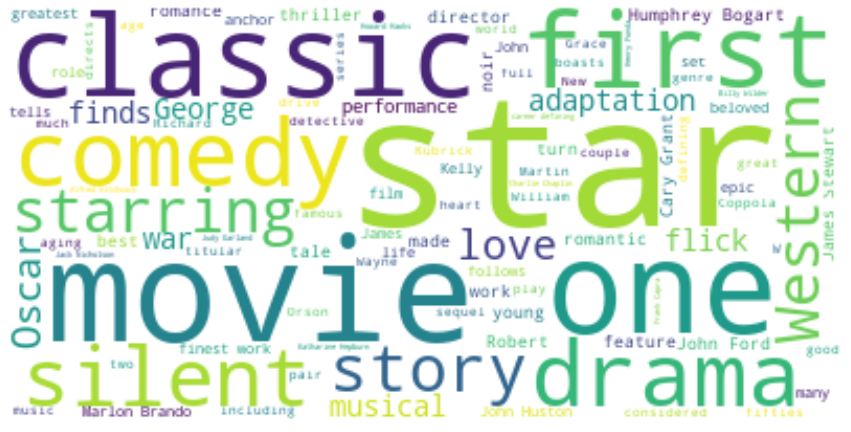

In [ ]:
# Wordcloud of Summary
text = " ".join(i for i in df['summary'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Fine tuning of T5 model

In [ ]:
# set the model architecture
model_checkpoint = "t5-base"

# get a tokenizer that corresponds to the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
# set the maximum length accepted by the model
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "


def preprocess_function(examples):
  """Returns a list of lists for each key by the tokenizer"""
  inputs = [prefix + doc for doc in examples["document"]]
  model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

  with tokenizer.as_target_tokenizer():
      model_inputs = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

  model_inputs["labels"] = model_inputs["input_ids"]
  return model_inputs

In [ ]:
# convert pandas dataframe into Hugging Face Hub's Dataset
dataset = Dataset.from_pandas(df[['document', 'summary']])

# apply the function on the Dataset
tokenized_dataset =dataset.map(preprocess_function)

  0%|          | 0/100 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3543: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [ ]:
# set the initial value
batch_size = 10
learning_rate = 0.0001
weight_decay = 0.01

In [ ]:
# load a pretrained model
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# initialize the optimizer 
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)

# compile the model
model.compile(optimizer=optimizer)

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# initialize data collator, which will not only pad the inputs to the maximum 
# length in the batch, but also the labels
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

# convert the Dataset into tf.data.Dataset
train_dataset = model.prepare_tf_dataset(
    tokenized_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

In [ ]:
# train the model
model.fit(train_dataset, epochs=10)

Epoch 1/10
10/10 [==============================] - 46s 272ms/step - loss: 0.1778
Epoch 2/10
10/10 [==============================] - 3s 281ms/step - loss: 0.0224
Epoch 3/10
10/10 [==============================] - 3s 273ms/step - loss: 0.0061
Epoch 4/10
10/10 [==============================] - 3s 274ms/step - loss: 0.0049
Epoch 5/10
10/10 [==============================] - 3s 275ms/step - loss: 0.0038
Epoch 6/10
10/10 [==============================] - 3s 277ms/step - loss: 0.0037
Epoch 7/10
10/10 [==============================] - 3s 279ms/step - loss: 0.0026
Epoch 8/10
10/10 [==============================] - 3s 279ms/step - loss: 0.0103
Epoch 9/10
10/10 [==============================] - 3s 285ms/step - loss: 0.0020
Epoch 10/10
10/10 [==============================] - 3s 282ms/step - loss: 0.0024


# Inference

In [ ]:
def concat_document(title, director, starring, content):
  """Concats movie's title, director, starring and content"""
  return 'summarize: The title is ' + title + '. The director is ' + director + '. The starrings are ' + starring + '. ' + content

In [ ]:
# Example 1: Star Wars (1977)
title1 = 'Star Wars (1977)'
director1 = 'George Lucas'
starring1 = 'Harrison Ford, Mark Hamill, James Earl Jones, Alec Guinness, Carrie Fisher, Peter Cushing'
content1 = 'The first of a trilogy of fantasy films by writer/director George Lucas, and one of the most financially-successful films of all time, with amazing technological effects. A sci-fi adventure saga "in a galaxy far, far away", quasi-Western film, about a galactic battle between good (the rebel forces) and evil (the Imperial Galactic Empire). The characters are proto-typical: a young farmboy hero Luke Skywalker (Hamill) on a desert planet, a villainous, black-garbed sinister Lord Darth Vader (voice of Jones) - an aide to the leader of the Empire Grand Moff Tarkin (Cushing), a wise Jedi knight Obi-Wan Kenobi (Guinness), a daring starship pilot (Ford), a captured rebel Princess Leia Organa (Fisher), a furry Wookie and two robotic droids. With two sequels, The Empire Strikes Back and Return of the Jedi. Academy Award Nominations: 10, including Best Picture, Best Supporting Actor--Alec Guinness, Best Director, and Best Screenplay. Academy Awards: 6, including Best Sound, Best Original Score, Best Film Editing, Best Costume Design, Best Art Direction/Set Decoration, Best Visual Effects. A Special Achievement Award for "creation of the alien, creature, and robot voices."'
document1 = concat_document(title1, director1, starring1, content1)

In [ ]:
# predict and print the summary
tokenized1 = tokenizer([document1], return_tensors='np')
out1 = model.generate(**tokenized1, max_length=128)

with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out1[0]))

<pad> "in a galaxy far, far away", quasi-Western film, about a galactic battle between good (the rebel forces) and evil (the Imperial Galactic Empire).</s>


In [ ]:
# Example 2: Titanic (1997)
title2 = 'Titanic (1997)'
director2 = 'James Cameron'
starring2 = 'Leonardo DiCaprio, Kate Winslet, Billy Zane, Kathy Bates, Bill Paxton, Gloria Stuart, Frances Fisher'
content2 = "Writer/director James Cameron's three-plus hour, epic mega-blockbuster with the most expensive budget of any film up to its time, and extravagant visual and digital effects. Its story centered around an infamous part of history (the fateful night of April 15, 1912 for White Star Line's R.M.S. Titanic) with a doomed, fictional romance at its core. It begins with treasure-seekers in a salvage expedition at the submerged ship led by Brock Lovett (Paxton), who discover a safebox with a drawing of a woman wearing a 56-carat blue diamond necklace. They connect it to 102 year-old survivor Rose Dawson Calvert (Stuart) who revisits the site of the sinking, and reminisces, in flashback, about an ill-fated, forbidden romance she had when she was a seventeen year-old society girl. with lower-class, starving artist Jack Dawson (DiCaprio). Earlier a debutante named Rose DeWitt Bukater (Winslet), she had been forced by her mother Ruth (Fisher) to become engaged to rich, arrogant socialite Cal Hockley (Zane) and was on her way to Philadelphia to marry. Feeling hopelessly trapped, she tried to commit suicide from the aft deck rather than accept the arranged marriage, but was rescued by Jack. Although Jack was slighted by her upper-class family, she forsook her future with Cal and asked Jack to sketch her in the nude wearing the invaluable blue diamond, and they fell in love. When the ship hit the iceberg in the frigid North Atlantic and split in two, Jack sacrificed himself and again saved her from sure death. The characters of Rose and Jack and their romance wisely dominate the film, although there are some secondary subplots. Fans (mostly female) returned many dozens of times to enjoy the tale over and over and helped the film become the highest grossing motion picture of all time. Although praised by critics and the viewing public, there was some backlash about its acting (especially DiCaprio's) and its screenplay - Titanic became the first Best Picture winner to not have a Best Screenplay nomination since The Sound of Music (1965). Academy Award Nominations: 14, including Best Actress--Kate Winslet, Best Supporting Actress--Gloria Stuart, Best Makeup. Academy Awards: 11, including Best Picture, Best Director--James Cameron, Best Cinematography--Russell Carpenter, Best Costume Design, Best Art Direction-Set Decoration, Best Film Editing, Best Original Score--James Horner, Best Original Song--'My Heart Will Go On,' Best Visual Effects, Best Sound Editing, Best Sound Effects Editing."
document2 = concat_document(title2, director2, starring2, content2)

In [ ]:
tokenized2 = tokenizer([document2], return_tensors='np')
out2 = model.generate(**tokenized2, max_length=128)

with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out2[0]))

Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors


<pad> the three-plus hour, epic mega-blockbuster with the most expensive budget of any film up to its time, and extravagant visual and digital effects.</s>


# Pysummarization

In [ ]:
# Object of automatic summarization
auto_abstractor = AutoAbstractor()
# Set tokenizer
auto_abstractor.tokenizable_doc = SimpleTokenizer()
# Set delimiter for making a list of sentence
auto_abstractor.delimiter_list = [".", "\n"]
# Object of abstracting and filtering document
abstractable_doc = TopNRankAbstractor()

In [ ]:
# Example 1: Star Wars (1977)
# Summarize document1
result_dict1 = auto_abstractor.summarize(document1, abstractable_doc)
# Display only the most critical line from the summary
top_row1 = result_dict1["scoring_data"].index(max(result_dict1["scoring_data"], key=operator.itemgetter(1)))
print(result_dict1["summarize_result"][top_row1])

 The characters are proto-typical: a young farmboy hero Luke Skywalker (Hamill) on a desert planet, a villainous, black-garbed sinister Lord Darth Vader (voice of Jones) - an aide to the leader of the Empire Grand Moff Tarkin (Cushing), a wise Jedi knight Obi-Wan Kenobi (Guinness), a daring starship pilot (Ford), a captured rebel Princess Leia Organa (Fisher), a furry Wookie and two robotic droids.



In [ ]:
# Example 2: Titanic (1997)
result_dict2 = auto_abstractor.summarize(document2, abstractable_doc)
top_row2 = result_dict2["scoring_data"].index(max(result_dict2["scoring_data"], key=operator.itemgetter(1)))
print(result_dict2["summarize_result"][top_row2])

 It begins with treasure-seekers in a salvage expedition at the submerged ship led by Brock Lovett (Paxton), who discover a safebox with a drawing of a woman wearing a 56-carat blue diamond necklace.

